In [15]:
import argparse
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
from RainExtreme import RainExtremes

In [79]:
from myImports import *

class RainExtremes:
    def __init__(self, name = 'DYAMOND', region = '130E_165E_0N_20N', sim = 'SAM'):
        self.name = name
        self.region = region
        self.sim = sim
        self.path = '/scratchu/bfildier/'+self.name+'_REGIONS/'+self.region+'/'+self.sim+'/'
        self.path_data2d = self.path + '2D/' ## goesfrom 4608_0000000240 to 4608_0000460800
        self.data_names = ['CWP', 'LHF', 'OM500', 'OM850', 'Precac', 'PSFC', 'PW', 'RH500', 'SHF', 'T2mm', 'U10m', 'V10m']
        self.path_label = self.path + 'TOOCAN_SEG/'   ## goes from 20160801-i to 20161001-i with i in [0,40] 
        self.path_safeguard = '/homedata/mcarenso/Stage2023/'+self.name+'_REGIONS/'+self.region+'/'+self.sim+'/'

        self.df = self.loadRelTable()
                    ## pick the first file in path_data2d

        for file in os.listdir(self.path_data2d):
            self.template_native_df = xr.open_dataset(self.path_data2d+file)
            break
        
        ##check if there is a file all.nc in safegard folder, if no build it else, load it
        if os.path.isfile(self.path_safeguard+'all.nc'):
            self.ds = xr.open_dataset(self.path_safeguard+'all.nc')
            self.lat_centers, self.lon_centers = self.template_native_df['lat'].values, self.template_native_df['lon'].values
            self.lat_length_on_center, self.lat_centers_contrib_to_global, self.lat_contrib_on_global, self.lat_global = self.compute_pixel_length_and_contrib_to_global_and_global(self.template_native_df, 'lat')
            self.lon_length_on_center, self.lon_centers_contrib_to_global, self.lon_contrib_on_global, self.lon_global = self.compute_pixel_length_and_contrib_to_global_and_global(self.template_native_df, 'lon')
        else:
            self.ds  = self.build_xarray()
            self.ds.to_netcdf(self.path_safeguard+'all.nc')

        # self.main()

    def main(self):
        
        for i_t in range(1, len(self.df)):
            precip = self.loadPrec(i_t, self.df)
            da_precip_i_t = xr.DataArray(precip, dims = ['lat', 'lon'], coords = {'lat': self.template_native_df['lat'].values, 'lon': self.template_native_df['lon'].values})
            
    def build_xarray(self):
        
        self.lat_centers, self.lon_centers = self.template_native_df['lat'].values, self.template_native_df['lon'].values
        
        self.lat_length_on_center, self.lat_centers_contrib_to_global, self.lat_contrib_on_global, self.lat_global = self.compute_pixel_length_and_contrib_to_global_and_global(self.template_native_df, 'lat')
        self.lon_length_on_center, self.lon_centers_contrib_to_global, self.lon_contrib_on_global, self.lon_global = self.compute_pixel_length_and_contrib_to_global_and_global(self.template_native_df, 'lon')

        self.pixel_surface = self.lat_length_on_center[:,None] * self.lon_length_on_center[None,:]
        
        da = xr.DataArray(self.pixel_surface, dims = ['lat', 'lon'], coords = {'lat': self.template_native_df['lat'].values, 'lon': self.template_native_df['lon'].values})
        
        self.global_pixel_surface = self.sum_data_from_center_to_global(self.pixel_surface)

        da_global = xr.DataArray(self.global_pixel_surface, dims = ['lat_global', 'lon_global'], coords = {'lat_global': self.lat_global, 'lon_global': self.lon_global})

        # da_lat_contrib = xr.DataArray(np.array(self.lat_centers_contrib_to_global, dtype=object), dims = ['lat'], coords = {'lat': self.lat_centers})
        # da_lon_contrib = xr.DataArray(np.array(self.lon_centers_contrib_to_global, dtype=object), dims = ['lon'], coords = {'lon': self.lon_centers})
        
        ds = xr.Dataset({'pixel_surf': da, 'global_pixel_surf': da_global})
        
        return ds

    def loadPrec(self, i_t,df):
        
        # Load DYAMOND-SAM Precac
        precac_prev = self.loadPrecac(i_t-1,df)
        precac_current = self.loadPrecac(i_t,df)
        
        # get 30mn precipitation from difference
        prec = precac_current - precac_prev
        prec.rename('precipitation')
        
        # free up memory
        del precac_prev
        del precac_current
        gc.collect()
        
        return prec

    def loadPrecac(self, i_t, df):
        
        root = df.iloc[i_t]['path_dyamond']
        if type(root) != str : print(root)
        file_precac = root+'.Precac.2D.nc'
        # load
        precac = xr.open_dataarray(os.path.join(self.path_data2d, file_precac)).load()[0]
        return precac
    
    def loadRelTable(self, which='DYAMOND_SEG'):
        
        # relation table DYAMOND-SAM -- TOOCAN segmentation masks
        if which == 'DYAMOND_SEG':
            df = pd.read_csv('/home/mcarenso/code/stage-2023-multiscale-extremes/input/relation_2_table_UTC_dyamond_segmentation.csv')
            df.sort_values(by='UTC',ignore_index=True,inplace=True)
        return df
    
    def sum_data_from_center_to_global(self, data_on_center):
        data_on_global = np.zeros((len(self.lat_global), len(self.lon_global)))
        
        for i_lat, lat_center, lat_contrib in zip(range(len(self.lat_centers)), self.lat_centers, self.lat_centers_contrib_to_global):
            for j_lon, lon_center, lon_contrib in zip(range(len(self.lon_centers)), self.lon_centers, self.lon_centers_contrib_to_global):
                ## define get global_index_from_centers_and_contrib
                idx_lat = self.lat_global.index(np.floor(lat_center))
                idx_lon = self.lon_global.index(np.floor(lon_center))
                if type(lat_contrib) == tuple and lat_center > int(np.round(lat_center)):
                    idx_lat -= 1
                if type(lon_contrib) == tuple and lon_center > int(np.round(lon_center)):
                    idx_lon -= 1
                
                if type(lat_contrib) == tuple and type(lon_contrib) == tuple:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib[0] * lon_contrib[0]
                    data_on_global[idx_lat+1, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib[1] * lon_contrib[0]
                    data_on_global[idx_lat, idx_lon+1] += data_on_center[i_lat, j_lon] * lat_contrib[0] * lon_contrib[1]
                    data_on_global[idx_lat+1, idx_lon+1] += data_on_center[i_lat, j_lon] * lat_contrib[1] * lon_contrib[1]
                
                elif type(lat_contrib) == tuple and type(lon_contrib)==int:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib[0] * lon_contrib
                    data_on_global[idx_lat+1, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib[1] * lon_contrib
                        
                elif type(lat_contrib) == int and type(lon_contrib)==tuple:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib * lon_contrib[0]
                    data_on_global[idx_lat, idx_lon+1] += data_on_center[i_lat, j_lon] * lat_contrib * lon_contrib[1]

                elif type(lat_contrib) == int and type(lon_contrib)==int:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib * lon_contrib

        return data_on_global
      
    def mean_data_from_center_to_global(self, data_on_center):
        data_on_global = np.zeros((len(self.lat_global), len(self.lon_global)))
        
        data_on_center = data_on_center * self.ds['pixel_surf']
        
        for i_lat, lat_center, lat_contrib in zip(range(len(self.lat_centers)), self.lat_centers, self.lat_centers_contrib_to_global):
            for j_lon, lon_center, lon_contrib in zip(range(len(self.lon_centers)), self.lon_centers, self.lon_centers_contrib_to_global):
                ## define get global_index_from_centers_and_contrib
                idx_lat = self.lat_global.index(np.floor(lat_center))
                idx_lon = self.lon_global.index(np.floor(lon_center))
                if type(lat_contrib) == tuple and lat_center > int(np.round(lat_center)):
                    idx_lat -= 1
                if type(lon_contrib) == tuple and lon_center > int(np.round(lon_center)):
                    idx_lon -= 1
                
                if type(lat_contrib) == tuple and type(lon_contrib) == tuple:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon]  * lat_contrib[0] * lon_contrib[0]
                    data_on_global[idx_lat+1, idx_lon] += data_on_center[i_lat, j_lon]  * lat_contrib[1] * lon_contrib[0]
                    data_on_global[idx_lat, idx_lon+1] += data_on_center[i_lat, j_lon]  * lat_contrib[0] * lon_contrib[1]
                    data_on_global[idx_lat+1, idx_lon+1] += data_on_center[i_lat, j_lon]  * lat_contrib[1] * lon_contrib[1]
                
                elif type(lat_contrib) == tuple and type(lon_contrib)==int:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib[0] * lon_contrib
                    data_on_global[idx_lat+1, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib[1] * lon_contrib
                        
                elif type(lat_contrib) == int and type(lon_contrib)==tuple:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib * lon_contrib[0]
                    data_on_global[idx_lat, idx_lon+1] += data_on_center[i_lat, j_lon] * lat_contrib * lon_contrib[1]

                elif type(lat_contrib) == int and type(lon_contrib)==int:
                    data_on_global[idx_lat, idx_lon] += data_on_center[i_lat, j_lon] * lat_contrib * lon_contrib

        return data_on_global
  
    def compute_pixel_length_and_contrib_to_global_and_global(self, template_df, coord):
    
        coord_centers = template_df[coord].values
        coord_borders = self.__get_coord_border_from_centers__(coord_centers)
        coord_global = [coord for coord in range(int(np.floor(coord_centers[0])), int(np.ceil(coord_centers[-1])), 1)]
        length_on_center = np.diff(coord_borders)
        centers_contrib_to_global = self.__compute_contrib_from_borders__(coord_borders)
        
        # store them with one list per global coord      
        contrib_on_global_coord = self.__compute_contrib_on_global_coord_from_centers(centers_contrib_to_global, coord_centers, length_on_center, coord_global)

        return(length_on_center,centers_contrib_to_global, contrib_on_global_coord, coord_global)     
    
    def __get_coord_border_from_centers__(self, coord_centers):
        coord_borders = list()
        coord_borders.append(np.floor(coord_centers[0]))
        for i in range(len(coord_centers)-1):
            coord_borders.append((coord_centers[i]+coord_centers[i+1])/2)
        coord_borders.append(np.ceil(coord_centers[-1]))  
        return coord_borders
    
    def __compute_contrib_from_borders__(self, coord_borders):
        centers_contrib_to_global = []
        for coord_length, border_left, border_right in zip(np.diff(coord_borders), coord_borders[:-1], coord_borders[1:]):   
            if np.floor(border_left) != np.floor(border_right):
                # print(lat_length, border_left, border_right)
                left_contrib =  (np.ceil(border_left) - border_left)/coord_length
                right_contrib = (border_right - np.floor(border_right))/coord_length
                if right_contrib ==  0 : 
                    centers_contrib_to_global.append((1))
                else : 
                    centers_contrib_to_global.append((left_contrib, right_contrib))
            else : 
                contrib = 1
                centers_contrib_to_global.append((contrib))
                
        
        return centers_contrib_to_global     
    
    def __compute_contrib_on_global_coord_from_centers(self, centers_contrib_to_global, coord_centers, length_on_center, coord_global): 
        contrib_on_global_coord = [[] for _ in range(len(coord_global))]
        #print(coord, len(centers_contrib_to_global), len(coord_centers), len(length_on_center))
        for contrib, coord_center, data in zip(centers_contrib_to_global,coord_centers, length_on_center):
            idx_coord = coord_global.index(np.floor(coord_center))
            ## test if contrib is a tuple or not
            if type(contrib) == tuple:
                if contrib[1] != 0:
                    ##print(coord, contrib, coord_center, idx_coord)
                    ##print(int(np.round(coord_center)))
                    if coord_center > int(np.round(coord_center)):
                        contrib_on_global_coord[idx_coord-1].append(contrib[0]*data)
                        contrib_on_global_coord[idx_coord].append(contrib[1]*data)
                    elif coord_center < int(np.round(coord_center)):
                        contrib_on_global_coord[idx_coord].append(contrib[0]*data)
                        contrib_on_global_coord[idx_coord+1].append(contrib[1]*data)
                    else : print('weird')
                else:
                    contrib_on_global_coord[idx_coord].append(contrib[0]*data) ## contrib[0] = 1
            elif type(contrib) == int:
                contrib_on_global_coord[idx_coord].append(contrib*data) ## contrib == 1
                
        return contrib_on_global_coord   

In [80]:
self=RainExtremes() 

In [87]:
for i_t in range(len(self.df)):
    precip = self.loadPrec(i_t, self.df)
    precip_cg_global = self.mean_data_from_center_to_global(precip)
    break

In [86]:
len(self.df)

1918

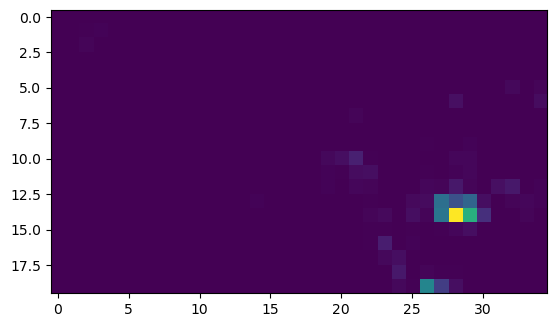

In [85]:
plt.imshow(save_precip_cg_1)

(518, 896)


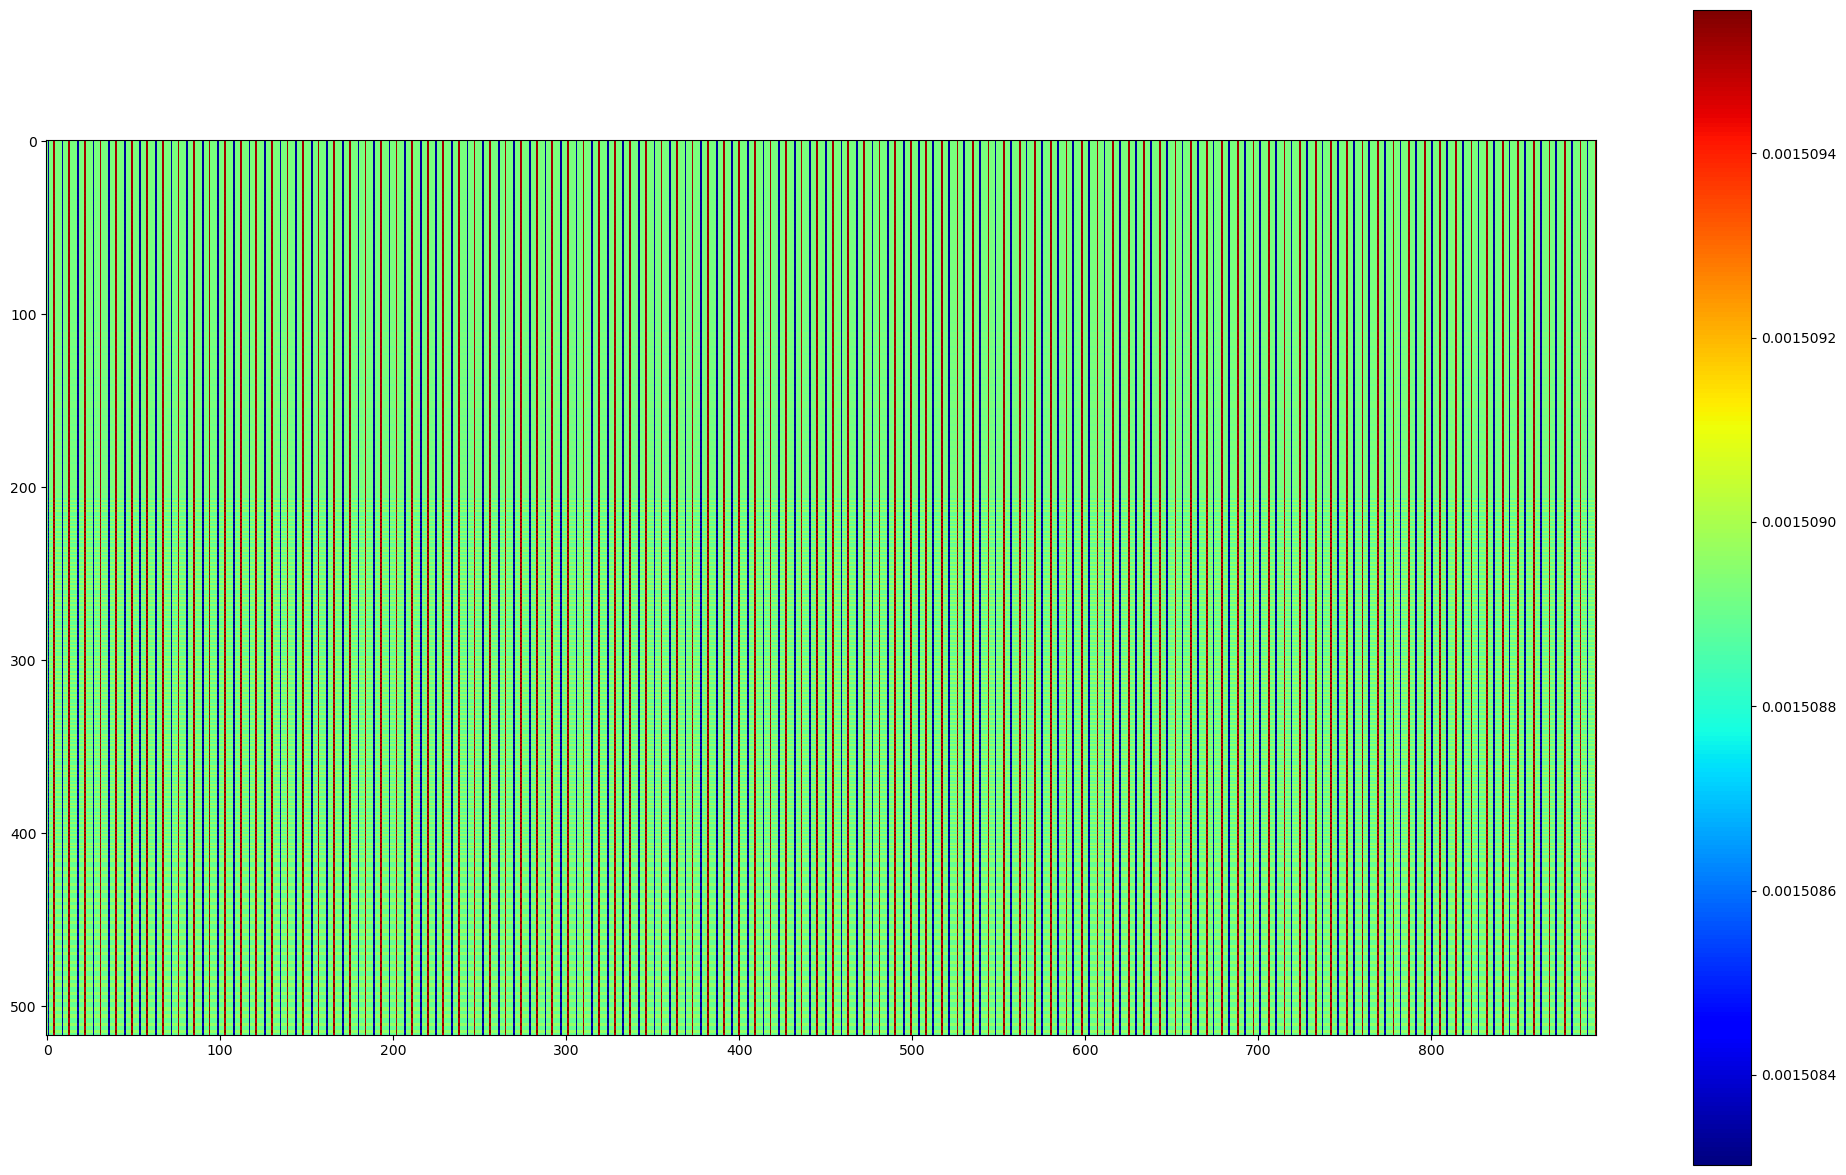

In [32]:
## Plot pixel surface

fig = plt.figure(figsize = (25, 15))    
X = self.ds['pixel_surf'].values  

print(X.shape)
plt.imshow(X[0:517], cmap = 'jet', interpolation='nearest')
plt.colorbar()